<a href="https://colab.research.google.com/github/dmdwn99/Computer-Vision-Study/blob/main/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컨볼루션 신경망


## 1. 특징 추출

이미지 데이터의 특징 추출 기법 중 하나인 컨볼루션 연산은 각 픽셀을 본래 픽셀과 그 주변 픽셀의 조합으로 대체하는 동작이다. 연산에 쓰이는 작은 행렬을 필터 또는 커널이라고 한다. 원본 이미지의 각 픽셀을 포함한 주변 픽셀과 필터의 모든 픽셀은 각각 곱연산을 하고, 그 결과를 모두 합해서 새로운 이미지를 만든다. 

이러한 과정이 수작업일 경우 세 가지 문제점이 있다. 첫째, 적용하고자 하는 분야에 대한 전문적 지식 필요, 둘째, 시간과 비용이 많이 듬, 셋째, 한 분야엣 효과적인 특징을 다른 분야에 적용하기 어려움. 딥러닝 기반의 컨볼루션 연산은 **네트워크가 특징을 추출하는 필터를 자동으로 생성**하므로 위 문제점을 모두 해결한다.

## 2. 주요 레이어


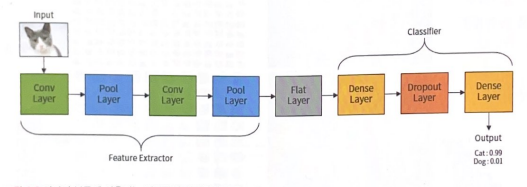

위 그림은 이미지 분류에 사용되는 컨볼루션 신경망의 구조이다. 특징 추출기에는 컨볼루션 레이어, 풀링 레이어가 교차되며 배치된다. 분류기에는 Dense 레이어가 배치되며 과적합을 막기 위해 드롭아웃 레이어가 Dense 레이어 사이에 배치된다.

### 2.1 컨볼루션 레이어

컨볼루션 레이어는 컨볼루션 연산을 하는 레이어다. 여기서 사용되는 필터는 네트워크의 학습을 통해 자동으로 추출된다. 필터의 수는 특징의 다양성과 비례한다.

이미지는 원색으로 구성된 채널이 있다. 채널이란 각 이미지가 가진 색상에 대한 정보를 분리해서 담아놓는 공간이다. 흑백 이미지는 각 픽셀에 대한 정보가 담긴 채널이 1개이고, 컬러 이미지는 빨강, 초록, 파랑의 삼원색으로 된 3개의 채널을 가지고 있다. 컨볼루션 레이어는 각 채널에 대해 계산된 값을 합쳐서 새로운 이미지를 만들어낸다. 이때 새로운 이미지의 마지막 차원 수는 필터의 수와 같다.

24576/15922 [==============================================] - 0s 0us/step


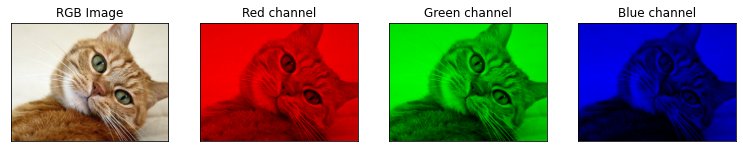

In [1]:
# 컬러 이미지에서 Red, Green, Blue 채널 이미지 분리
import tensorflow as tf
import matplotlib.pyplot as plt

image_path = tf.keras.utils.get_file('cat.jpg', 'http://bit.ly/33U6mH9')
image = plt.imread(image_path)

titles = ['RGB Image', 'Red channel', 'Green channel', 'Blue channel']
cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

from numpy import array, zeros_like
def channel(image, color):
    if color not in (0, 1, 2): return image
    c = image[..., color]
    z = zeros_like(c)
    return array([(c, z, z), (z, c, z), (z, z, c)][color]).transpose(1,2,0)
  
colors = range(-1, 3)
fig, axes = plt.subplots(1, 4, figsize=(13,3))
objs = zip(axes, titles, colors)
for ax, title, color in objs:
    ax.imshow(channel(image, color))
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

Conv2D 레이어는 텐서플로우와 파이토치 양측에서 모두 지원하는 레이어로, 매우 기본적인 컨볼루션 레이어다. Conv2D 레이어의 주요 인수는 kernel_size, strides, padding, filters 이다. 
- kernel_size: 필터 행렬의 크기, 앞의 숫자는 높이, 뒤의 숫자는 너비이고 숫자를 하나만 사용하면 높이와 너비를 동일한 값으로 사용한다는 뜻 
- strides: 필터가 계산 과정에서 한 스텝마다 이동하는 크기, 기본값은 (1,1)이고 (2,2)로 설정할 경우 한 칸씩 건너뛰면서 계산, 앞의 숫자는 높이, 뒤의 숫자는 너비이고 숫자를 하나만 사용하면 높이와 너비를 동일한 값으로 사용한다는 뜻
- padding: 컨볼루션 연산 전에 입력 이미지 주변에 빈 값을 넣을지 지정하는 옵션, valid는 빈 값을 사용하지 않는 것, same은 빈 값을 넣어서 출력하는 이미지의 크기를 입력과 같도록 보존, 빈 값으로 0이 쓰이는 경우를 제로 패딩이라 함
- filters: 필터의 개수, 많으면 다양한 특징을 추출하지만 학습 속도가 느려질 수 있고 과적합이 발생할 수 있음. 대표적인 컨볼루션 신경망인 VGG는 네트워크가 깊어질수록 필터의 수를 2배씩 늘려감

In [2]:
# 컨볼루션 레이어 생성
conv1 = tf.keras.layers.Conv2D(kernel_size=(3,3),strides=(2,2),padding='valid',filters=16)

### 2.2 풀링 레이어

이미지의 픽셀 중 인접한 픽셀들은 비슷한 정보를 갖고 있는 경우가 많은데, 이런 이미지의 크기를 줄이면서 중요한 정보만 남기기 위해 서브샘플링 기법을 사용한다. 이 기법은 효율적인 메모리 사용, 과적합 방지 등의 효과가 있다. 서브샘플링 과정에서 사용되는 레이어가 풀링 레이어다. 풀링 레이어에는 가중치가 없어 학습되지 않으며, 네트워크 구조에 따라 생략되기도 한다.

풀링 레이어에는 Max 풀링 레이어, Average 풀링 레이어 등이 있는데 컨볼루션 레이어에는 Max 풀링 레이거가 자주 사용된다. MaxPool2D 레이어의 주요 인수는 pool_size, strides 이다.
- pool_size: 한 번에 Max 연산을 수행할 범위, (2,2)일 경우 높이 2, 너비 2의 사각형 안에서 최댓값만 남기는 연산 수행
- strides: Conv2D 레이어와 동일


In [3]:
# 풀링 레이어 생성
pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))

### 2.3 드롭아웃 레이어

드롭아웃 레이어는 네트워크의 과적합을 막기 위한 레이어로 학습 과정에서 무작위로 뉴런의 부분집합을 제거하는 방식이다. 네트워크가 학습할 때 같은 레이어에 있는 뉴런들은 결괏값에 의해 서로 같은 영향을 받아서 각 뉴런의 계산 결과를 모두 더해서 나오는 결괏값은 한쪽으로 치우치게 된다. 이를 막기 위해 드롭아웃 레이어는 학습 과정에서는 확률적으로 일부 뉴런에 대한 연결을 끊고, 테스트할 때는 정상적으로 모든 값을 포함해서 계산한다.

Dropout 레이어에 주요 인수는 rate 이다. 드롭아웃 레이어도 가중치가 없기 때문에 학습되지 않는다.
- rate: 제외할 뉴런의 비율

In [4]:
drop1 = tf.keras.layers.Dropout(rate=0.3)

## 3. Fashion MNIST 데이터세트에 적용하기

분류에 대해 학습할 때 사용된 Fashion MNIST 데이터를 사용해 컨볼루션 레이어와 풀링 레이어 등을 사용하여 분류 문제를 풀 때 퍼포먼스가 얼마나 개선되는지 확인해보자. 

In [5]:
#Fashion MNIST 데이터셋 불러오기 및 정규화
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

train_X = train_X / 255.0
test_X = test_X / 255.0

4431872/4422102 [==============================] - 0s 0us/step


Fashion MNIST 데이터를 불러온 후 정규화를 한다. Conv2D 레이어로 컨볼루션 연산을 하기 위해 채널의 형태를 가진 데이터가 필요하므로 데이터의 shape을 변경한다.

In [6]:
# 데이터를 채널 형태인 3차원으로 변경
print(train_X.shape, test_X.shape)

train_X = train_X.reshape(-1,28,28,1)
test_X = test_X.reshape(-1,28,28,1)

print(train_X.shape, test_X.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


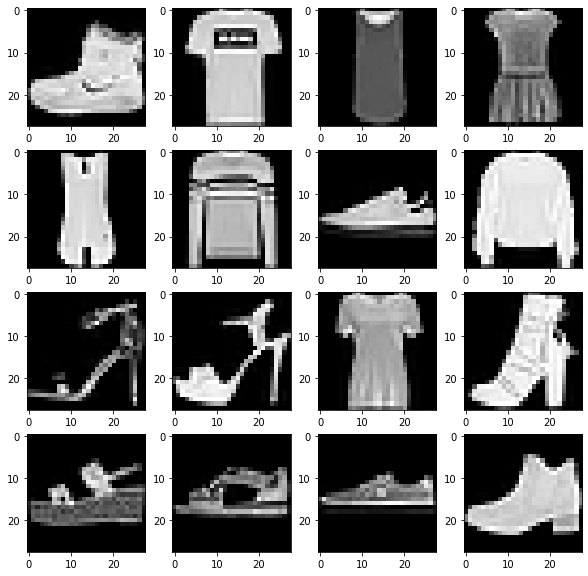

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9]


In [7]:
# 이미지 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10)) # 이미지 사이즈
for c in range(16):
  plt.subplot(4,4,c+1) #4행 
  plt.imshow(train_X[c].reshape(28,28), cmap='gray') # 이미지를 표현하려면 2차원이여야 하므로 reshape를 통해 차원 변경

plt.show()

print(train_Y[:16])

컨볼루션 신경망 모델을 생성하는데 풀링 레이어, 드롭아웃 레이어를 추가하지 않아서 각 레이어에 유무에 따른 성능 비교를 했다. 모델에는 총 3개의 컨볼루션 레이어를 사용했고 첫 번째 레이어에는 분류, 회귀 모델과 동일하게 input_shape를 지정했다. Flatten 레이어로 3차원 데이터를 1차원으로 정렬한 후, Dense 레이어로 분류한다.

In [8]:
# 컨볼루션 신경망을 사용한 분류 모델
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=16),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 128)               3965056   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,989,642
Trainable params: 3,989,642
Non-

Epoch 1/25
1407/1407 [==============================] - 20s 6ms/step - loss: 0.4599 - accuracy: 0.8372 - val_loss: 0.4486 - val_accuracy: 0.8423
Epoch 2/25
1407/1407 [==============================] - 8s 6ms/step - loss: 0.3378 - accuracy: 0.8759 - val_loss: 0.3584 - val_accuracy: 0.8717
Epoch 3/25
1407/1407 [==============================] - 11s 8ms/step - loss: 0.2840 - accuracy: 0.8957 - val_loss: 0.3879 - val_accuracy: 0.8667
Epoch 4/25
1407/1407 [==============================] - 8s 5ms/step - loss: 0.2461 - accuracy: 0.9083 - val_loss: 0.4031 - val_accuracy: 0.8663
Epoch 5/25
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2112 - accuracy: 0.9218 - val_loss: 0.4565 - val_accuracy: 0.8607
Epoch 6/25
1407/1407 [==============================] - 8s 5ms/step - loss: 0.1829 - accuracy: 0.9321 - val_loss: 0.5019 - val_accuracy: 0.8629
Epoch 7/25
1407/1407 [==============================] - 8s 6ms/step - loss: 0.1659 - accuracy: 0.9393 - val_loss: 0.5096 - val_accurac

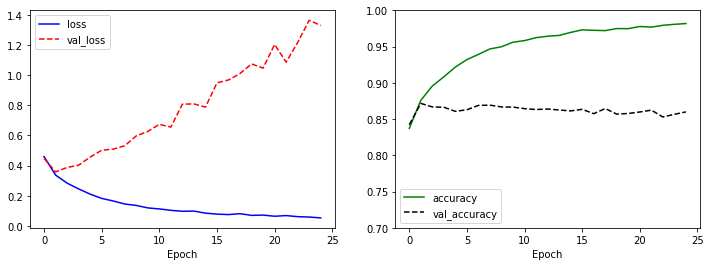

[1.397341251373291, 0.8543999791145325]

In [9]:
# 컨볼루션 신경망 모델 학습
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

모델 학습 결과 loss는 감소하는데 val_loss는 증가하는 과적합 현상을 보인다. 그렇기에 accuracy는 증가하지만 val_accuracy는 증가하지 않고 정체된다. 이를 개선하기 위해 풀링 레이어와 드롭아웃 레이어를 모두 사용해보았다.

In [10]:
 # 컨볼루션 신경망 모델 - 풀링 레이어, 드롭아웃 레이어 추가
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

summary() 함수를 통해 앞선 모델과 비교하였을 때 총 파라미터의 개수가 약 400만개에서 약 24만개로 감소하였는데 이는 풀링 레이어가 이미지의 크기를 줄이기 때문이다. Dense 레이어 사이에 사용된 드롭아웃 레이어는 과적합을 방지하게 된다.

Epoch 1/25
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5157 - accuracy: 0.8138 - val_loss: 0.3613 - val_accuracy: 0.8665
Epoch 2/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3552 - accuracy: 0.8713 - val_loss: 0.3252 - val_accuracy: 0.8803
Epoch 3/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3150 - accuracy: 0.8859 - val_loss: 0.3240 - val_accuracy: 0.8795
Epoch 4/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.2839 - accuracy: 0.8964 - val_loss: 0.2993 - val_accuracy: 0.8923
Epoch 5/25
1407/1407 [==============================] - 6s 5ms/step - loss: 0.2674 - accuracy: 0.9017 - val_loss: 0.3073 - val_accuracy: 0.8902
Epoch 6/25
1407/1407 [==============================] - 6s 5ms/step - loss: 0.2492 - accuracy: 0.9067 - val_loss: 0.2856 - val_accuracy: 0.8955
Epoch 7/25
1407/1407 [==============================] - 6s 5ms/step - loss: 0.2380 - accuracy: 0.9126 - val_loss: 0.3182 - val_accuracy:

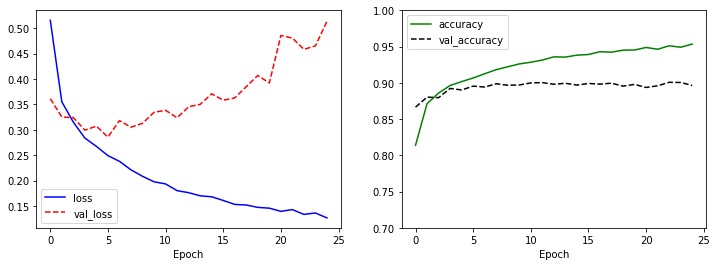

[0.5380449295043945, 0.8949000239372253]

In [11]:
# 컨볼루션 신경망 모델 학습 - 풀링 레이어, 드롭아웃 레이어 추가
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

val_loss가 증가하기는 하지만 앞선 모델과 비교하였을 때 보다는 안정적인 값을 보이고 있고 evaluate() 함수를 통해 테스트 데이터에 대한 평가 결과도 85% 에서 89%로 더 높은 성능을 보였다.

## 4. 퍼포먼스 높이기

컨볼루션 신경망에서 퍼포먼스를 높이는데 대표적인 두 가지 방법은 '더 많은 레이어 쌓기'와 '이미지 보강' 기법이다.

### 4.1 더 많은 레이어 쌓기

컨볼루션 신경망의 역사, 더 나아가 딥러닝의 역사는 더 깊은 신경망을 쌓기 위한 노력이라 할 수 있다. 컨볼루션 신경망은 컨볼루션 레이어가 중첩된 더 깊은 구조를 가질수록 퍼포먼스가 크게 개선되었다. VGGNet 스타일의 컨볼루션 신경망 모델을 통해 더 많은 레이어 쌓기에 대해 학습하였다.

In [12]:
# VGGNet 스타일의 컨볼루션 신경망 모델
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


feature extraction에 컨볼루션 레이어 2개를 사용한 뒤 풀링 레이어 1개를 사용하는 패턴을 2차례 반복하였다. 마지막 컨볼루션 레이어를 제외한 나머지 컨볼루션 레이어는 padding = 'same'를 설정했는데 이미지의 크기를 유지하기 위해서다. 풀링 레이어 다음에 드롭아웃 레이어를 배치해 과적합을 방지하였고, Flatten 레이어 뒤에 Dense 레이어를 3개 사용하여 레이어를 쌓았다. 

Epoch 1/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.5960 - accuracy: 0.7806 - val_loss: 0.3520 - val_accuracy: 0.8734
Epoch 2/25
1407/1407 [==============================] - 12s 8ms/step - loss: 0.3774 - accuracy: 0.8620 - val_loss: 0.2890 - val_accuracy: 0.8914
Epoch 3/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.3335 - accuracy: 0.8813 - val_loss: 0.2494 - val_accuracy: 0.9091
Epoch 4/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.3114 - accuracy: 0.8889 - val_loss: 0.2677 - val_accuracy: 0.9004
Epoch 5/25
1407/1407 [==============================] - 12s 8ms/step - loss: 0.2909 - accuracy: 0.8954 - val_loss: 0.2453 - val_accuracy: 0.9053
Epoch 6/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.2784 - accuracy: 0.8996 - val_loss: 0.2217 - val_accuracy: 0.9155
Epoch 7/25
1407/1407 [==============================] - 13s 9ms/step - loss: 0.2744 - accuracy: 0.9000 - val_loss: 0.2214 - val_ac

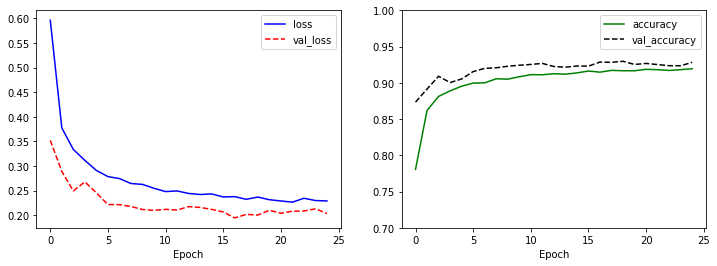

[0.21568037569522858, 0.9232000112533569]

In [13]:
# VGGNet 스타일의 컨볼루션 신경망 모델 학습
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

그래프를 보면 val_loss가 감소 추세를 보이는 것을 보아 모델 성능이 좋아졌음을 확인 할 수 있고 evaluate 결과 또한 92.3%로 우수한 성능을 보였다.

### 4.2 이미지 보강

이미지 보강은 훈련 데이터에 없는 이미지를 새롭게 만들어내서 훈련 데이터를 보강하는 것이다. 새로운 이미지는 훈련 데이터의 이미지를 원본으로 삼고 일정한 변형을 가해서 만들어진다. 이미지 보강은 ImageDataGenerator를 사용한다.

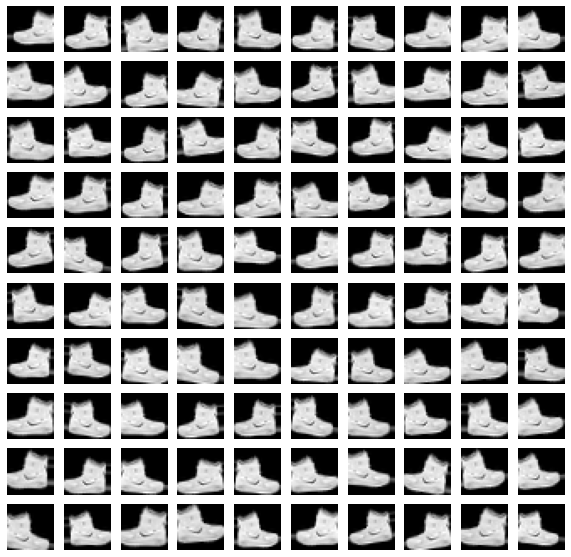

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.10,
            shear_range=0.5,
            width_shift_range=0.10,
            height_shift_range=0.10,
            horizontal_flip=True,
            vertical_flip=False)

augment_size = 100

x_augmented = image_generator.flow(np.tile(train_X[0].reshape(28*28),100).reshape(-1,28,28,1), 
                                   np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for c in range(100):
    plt.subplot(10,10,c+1)
    plt.axis('off')
    plt.imshow(x_augmented[c].reshape(28,28), cmap='gray')
plt.show()

신발 이미지가 여러 형태로 바뀐 것을 확인 할 수 있다. ImageDataGenerator의 주요 인수는 rotation_range, zoom_range, shear_range, horizontal_flip, vertical_flip 등이 있다. 
- rotation_range: 값을 0과 1 사이로 변경
- zoom_range: 무작위 줌 범위 설정
- shear_range: 층밀리기 강도 설정
- horizontal_flip: 이미지를 가로축으로 무작위로 뒤집음
- vertical_flip은: 이미지를 세로축으로 무작위로 뒤집음

flow()는 보강된 이미지를 생성하는 함수로 Iterator라는 객체를 만드는데, 이 객체에서는 값을 순차적으로 꺼낼 수 있다. next() 함수를 사용하여 값을 꺼내며 agument_size와 batch_size를 같게 설정했으므로 꺼내는 이미지는 100장이 된다. 

In [ ]:
# 이미지 보강
# 6.15 Image Augmentation
image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.10,
            shear_range=0.5,
            width_shift_range=0.10,
            height_shift_range=0.10,
            horizontal_flip=True,
            vertical_flip=False)

augment_size = 30000

randidx = np.random.randint(train_X.shape[0], size=augment_size)
x_augmented = train_X[randidx].copy()
y_augmented = train_Y[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

# 원래 데이터인 x_train 에 Image Augmentation 된 x_augmented 를 추가합니다.
train_X = np.concatenate((train_X, x_augmented))
train_Y = np.concatenate((train_Y, y_augmented))

print(train_X.shape)

(90000, 28, 28, 1)


훈련 데이터의 절반인 30000개의 이미지를 추가하기 위해 agument_size를 30000으로 하였고, 이미지 원본을 추출하기 위해 np.random.randint를 통해 30000개의 정수를 선택하였다. 이때 중복을 방지하고 싶으면 np.random.choice를 사용하면 된다.

x_argumented에 train_x의 이미지를 저장하는데 참조가 아닌 복사를 위해 copy() 함수를 사용했다. 그 다음 ImageDataGenerator를 통해 이미지를 생성하고 이를 train_X와 train_Y에 추가하기 위해 concatenate 함수를 사용했다. 

Epoch 1/25
2110/2110 [==============================] - 19s 9ms/step - loss: 0.5614 - accuracy: 0.7945 - val_loss: 0.5348 - val_accuracy: 0.7924
Epoch 2/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3700 - accuracy: 0.8668 - val_loss: 0.4886 - val_accuracy: 0.8132
Epoch 3/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3347 - accuracy: 0.8810 - val_loss: 0.4594 - val_accuracy: 0.8222
Epoch 4/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3169 - accuracy: 0.8853 - val_loss: 0.4395 - val_accuracy: 0.8398
Epoch 5/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.3026 - accuracy: 0.8905 - val_loss: 0.4106 - val_accuracy: 0.8476
Epoch 6/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.2950 - accuracy: 0.8941 - val_loss: 0.3968 - val_accuracy: 0.8520
Epoch 7/25
2110/2110 [==============================] - 18s 9ms/step - loss: 0.2874 - accuracy: 0.8975 - val_loss: 0.4067 - val_ac

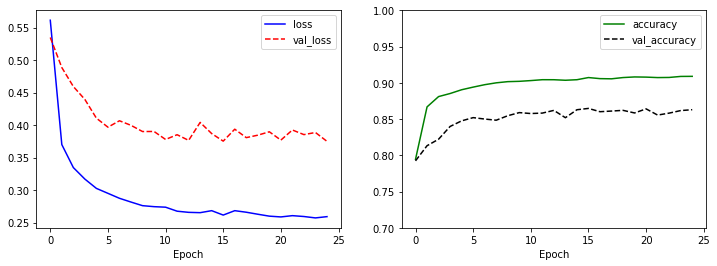

[0.20739753544330597, 0.9239000082015991]

In [ ]:
# 6.16 VGGNet style 네트워크 + Image Augmentation 학습
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

val_loss는 이미지 보강을 진행하지 않은 모델보다 높게 나왔지만 evaluate 함수를 통한 성능 평가는 92.3%에서 92.4%로 소폭 증가했다.